# Анализ оттока клиентов банка «Метанпром»

Ссылка на презентацию: https://drive.google.com/file/d/127DzLxAN_k6ExyDhurMB9Qhgya-82cth/view?usp=sharing

Банк «Метанпром» охватывает жителей Ярославля, Ростова Великого и Рыбинска. В ходе исследования мы сформулируем и проверим статистические гипотезы о наиболее подверженных к оттоку группах 

**Цель анализа** - изучить региональные особенности пользователей и представить портрет клиентов, которые склонны отказываться от услуг банка. клиентов.

**Датасет** - внутренние данные о клиентах банка «Метанпром».

**Содержание:**
1. [Исследовательский анализ данных](#1)
 - Загрузка и подготовка данных
 - Характеристики клиентов, поиск возможных аномалий

2. [Анализ клиентов попавших в отток](#2)
 - Какие показатели скоррелированы с оттоком в наибольшей степени?
 - Что объединяет ушедших клиентов?
 
3. [Проверка гипотез](#3)
 - Гипотеза различия дохода между ушедшими и оставшимися клиентами
 - Клиенты 45-65 лет подверженны оттоку в большей степени
 
 
4. [Общие выводы](#4)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st

sns.set_palette('Set2')

<a id="1"></a>
## Исследовательский анализ данных

<a id="1.1"></a>
### Загрузка и подготовка данных

In [2]:
df = pd.read_csv('bank_dataset_1.csv')
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


None

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


Перед нами данные о 10 000 клиентов банка.

1. **Для удобства приведём наименования колонок к нижнему регистру:**

In [3]:
df.columns = df.columns.str.lower()

2. **В начале таблицы заметны противоречия колонок "loyalty" и "churn". Будучи в оттоке клиент не может быть лояльным. Проверим, насколько много таких расхождений:**

In [4]:
print('Расхождение колонки лояльности и оттока:', df.query('loyalty == 1 and churn == 1').shape[0])

Расхождение колонки лояльности и оттока: 735


Колонка 'loyalty' несёт в себе устаревшую информацию. Мы не будем использовать её в ходе анализа.

In [5]:
df = df.drop('loyalty', axis=1)

3. **Проверим нваличие дубликатов:**

In [6]:
print('Дубликаты в данных:', df.drop('userid', axis=1).duplicated().sum())
print('Дубликаты в пользователях:', df['userid'].duplicated().sum())

Дубликаты в данных: 0
Дубликаты в пользователях: 0


4. **Согласно информации о датасете пропуски есть только в колонке "Баланс", что может сообщать о нулевом балансе и маловероятно является ошибкой. Проверим нулевые значения в других колонках:**

In [7]:
for column in df:
    if df[df[column] == 0][column].count() > 0:
        print(column, df[df[column] == 0][column].count())

objects 413
creditcard 2945
churn 7963


**Представленные города:**

In [8]:
print(df['city'].unique())

['Ярославль' 'Рыбинск' 'Ростов Великий']


### Характеристики клиентов, поиск возможных аномалий

In [9]:
df.describe()

,userid,score,age,objects,balance,products,creditcard,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,199992.480000,1.000000


Значение баллов кредитного скоринга:
- **300-500** - Нет шансов получить заем
- **600-650** - Низкий балл, крупные финансовые организации не рассматривают
- **650-690** - Хороший балл, есть шансы на одобрение займа со стандартными условиями
- **690-850** - Отличный балл, одобрить заем могут с более выгодными условиями

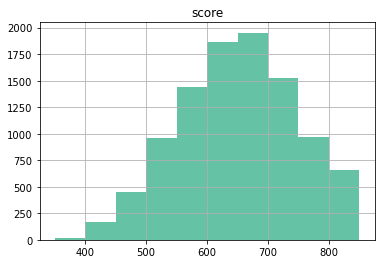

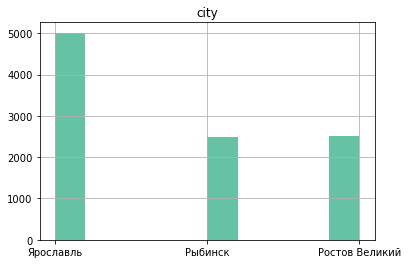

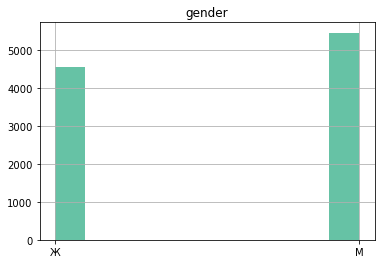

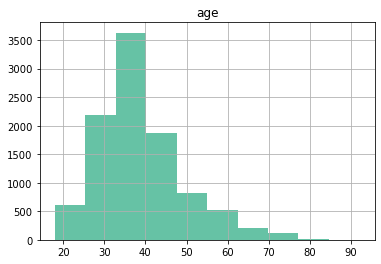

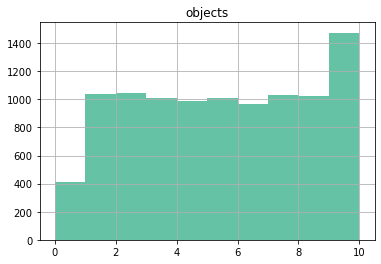

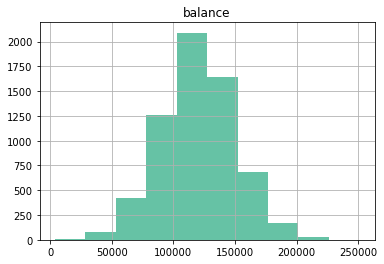

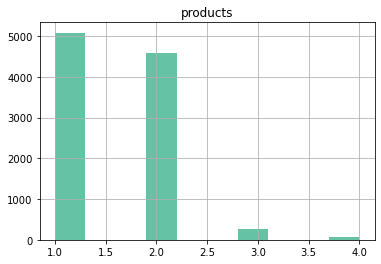

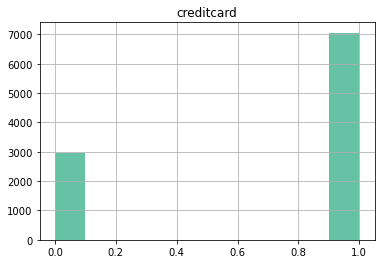

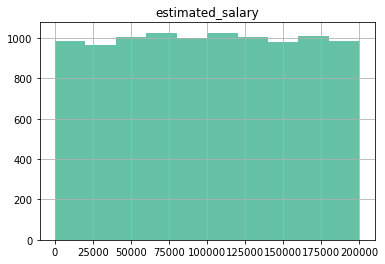

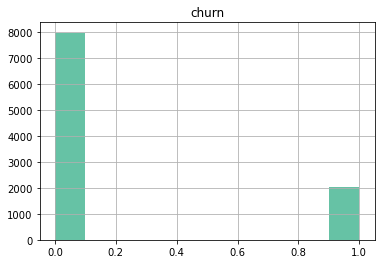

In [10]:
# создадим датафрейм для построения гистограм,
# в дальнейшем он будет так же использован в разделе"Что объединяет ушедших клиентов?"
for_hist = df.drop(['userid'], axis=1)

for column in for_hist:
    for_hist[column].hist()
    plt.title(column)
    plt.show()

### Портрет клиента банка:

- Почти половина клиентов в выборке (4 900 из 10 000) не обладают достаточным количеством баллов скоринга для получения кредита
- 45% женщин, 55% мужчин
- 50% жители Ярославля, и по 25% клиентов живёт в Рыбинске и Ростове
- Половина клиентов в возрасте 32-44 года 
- Клиенты редко пользуются больше, чем двумя продуктами
- 70% пользуется кредитными картами
- Уровень зарплат равномерно разделён в интервале от 0 до 200 000
- **20,4% оттока**

<a id="2"></a>
## Анализ клиентов попавших в отток 

### Какие показатели скоррелированы с оттоком в наибольшей степени?

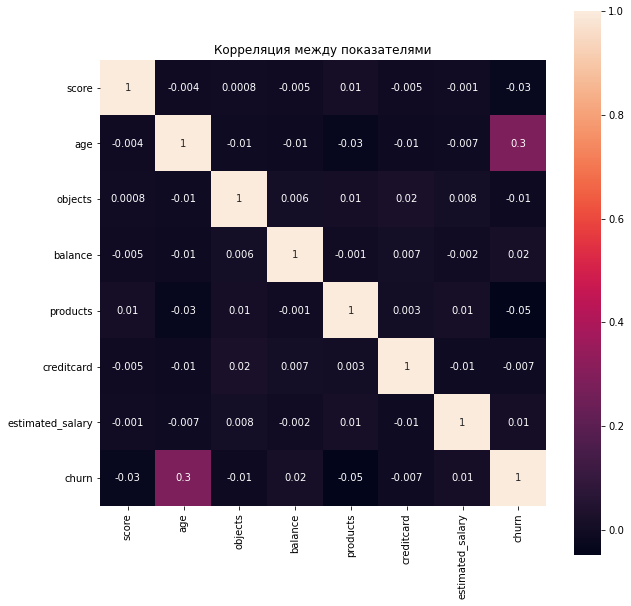

In [11]:
correlation = df.drop('userid', axis=1).corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, annot=True, square=True, fmt='.1g')
plt.title('Корреляция между показателями');

- Самая явная корреляция оттока с возрастом - 30%
- Минимальная корреляция - с наличием кредитной карты

### Что объединяет ушедших клиентов?

Очень высокий отток в возрасте 47-56

In [12]:
#for column in for_hist:
#    sns.kdeplot(for_hist.query('churn == 0')[column], shade = True, alpha=0.7, label='Churn=0')
#    sns.kdeplot(for_hist.query('churn == 1')[column], shade = True, alpha=0.7, label='Churn=1')
#    plt.legend()
#    plt.title(column)
#    plt.show()

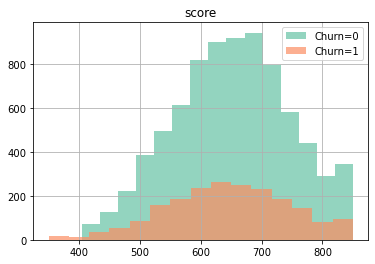

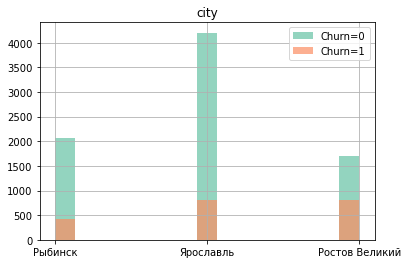

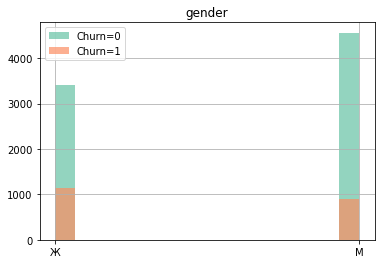

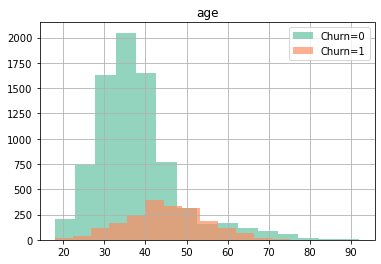

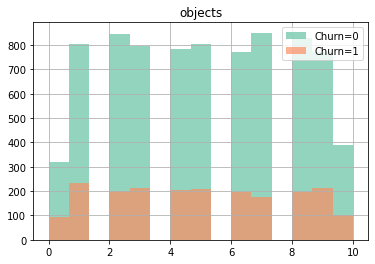

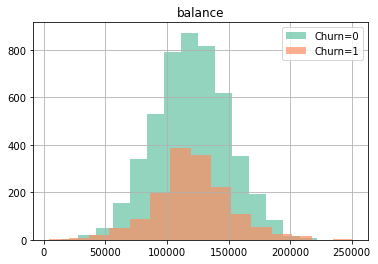

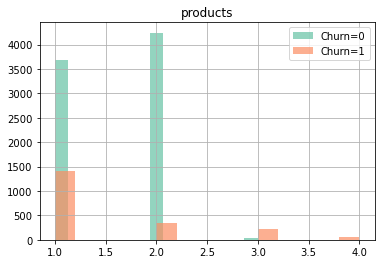

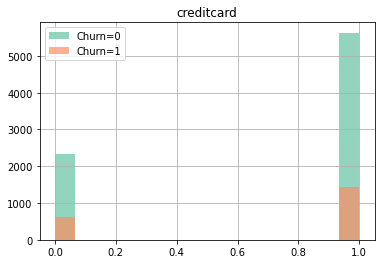

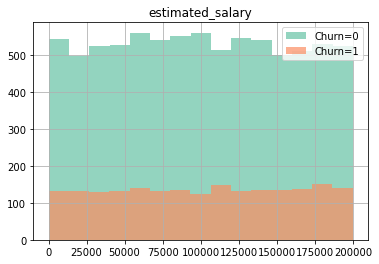

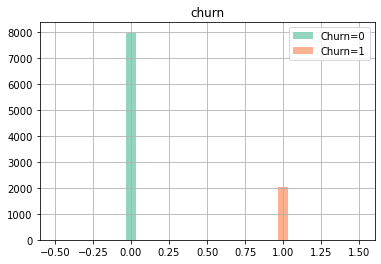

In [13]:
for column in for_hist:
    for_hist.query('churn == 0')[column].hist(bins=15, alpha=0.7, label='Churn=0')
    for_hist.query('churn == 1')[column].hist(bins=15, alpha=0.7, label='Churn=1')
    plt.legend()
    plt.title(column)
    plt.show()

**Заметные различия в распределении признаков:**
- В Ростове отток выше, чем в Ярославле и Рыбинске,
- Женщины прекращают обслуживание в банке чaще мужчин,
- Распределение возраста активных клиентов смещено левее (моложе) возраста ушедших клиентов,
- Пользователи 3-4 продуктов гораздо чаще уходят, чем остаются (отток - 85%: 280 ушло, 46 осталось).

В остальном видимых различий нет.

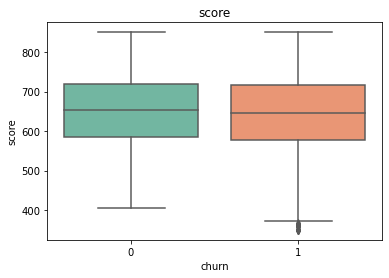

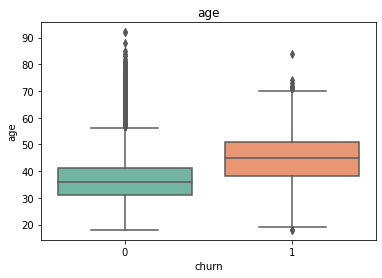

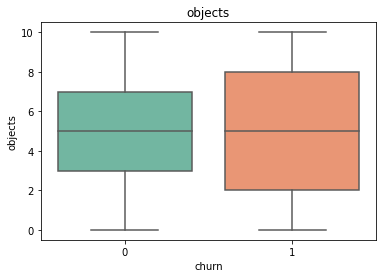

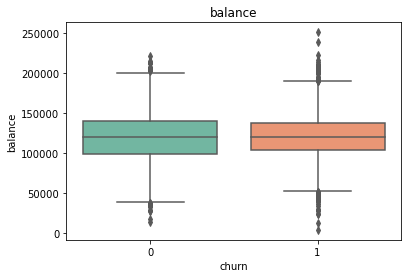

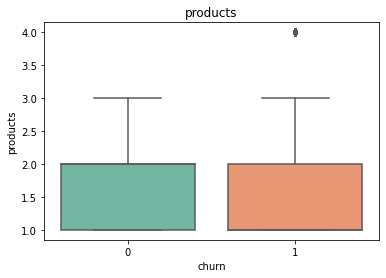

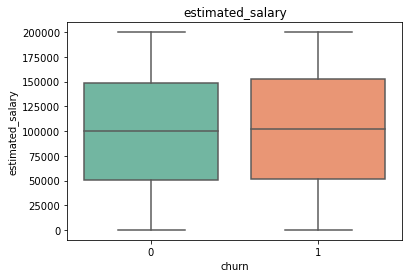

In [14]:
for column in df.drop(['userid', 'city', 'gender', 'creditcard', 'churn'], axis=1):
    sns.boxplot(y = column, x = 'churn', data= for_hist)
    plt.title(column)
    plt.show()

Среди небинарных признаков только **возраст имеет заметные различия между активными клиентами и клиентами в оттоке.** Как мы отметили выше, **к оттоку склонны клиенты постарше.**

**Категоризируем клиентов по уровню дохода и возрасту:**

Распределим клиентов по 4 уровням дохода (на 4 квартиля):
- Низкий:                11 - 51 001,
- Ниже среднего:         51 002 - 100 193
- Выше среднего:         100 194 - 149 388,
- Высокий:               149 389 - 199 993 

In [15]:
df['salary_level'] = pd.qcut(df['estimated_salary'], q=4, labels=['низкий', 'ниже_среднего', 'выше_среднего', 'высокий'])

Поделим клиентов на группы по возрастам:
- 18-25
- 25-35
- 35-45
- 45-65
- 65+

In [16]:
def age_level(row):
    i = row['age']
    if 18 <= i < 25:
        return '18-25'
    elif 25 <= i < 35:
        return '25-35'
    elif 35 <= i < 45:
        return '35-45'
    elif 45 <= i < 65:
        return '45-65'
    else:
        return '65+'

df['age_level'] = df.apply(age_level, axis=1)

df.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,estimated_salary,churn,salary_level,age_level
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,101348.88,1,выше_среднего,35-45
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,112542.58,0,выше_среднего,35-45
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,113931.57,1,выше_среднего,35-45
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,93826.63,0,ниже_среднего,35-45
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,79084.10,0,ниже_среднего,35-45


доля_оттока                     количество_в_оттоке          \
city          Ростов Великий   Рыбинск Ярославль      Ростов Великий Рыбинск   
salary_level                                                                   
низкий              0.355662  0.151515  0.146067                 627     627   
ниже_среднего       0.317957  0.157468  0.160532                 607     616   
выше_среднего       0.315287  0.169304  0.159677                 628     632   
высокий             0.309119  0.189369  0.179856                 647     602   

                         
city          Ярославль  
salary_level             
низкий             1246  
ниже_среднего      1277  
выше_среднего      1240  
высокий            1251

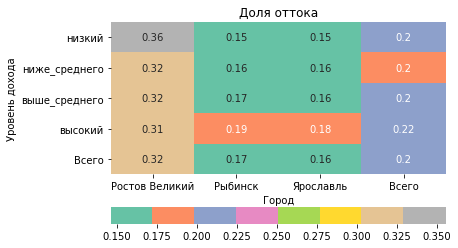

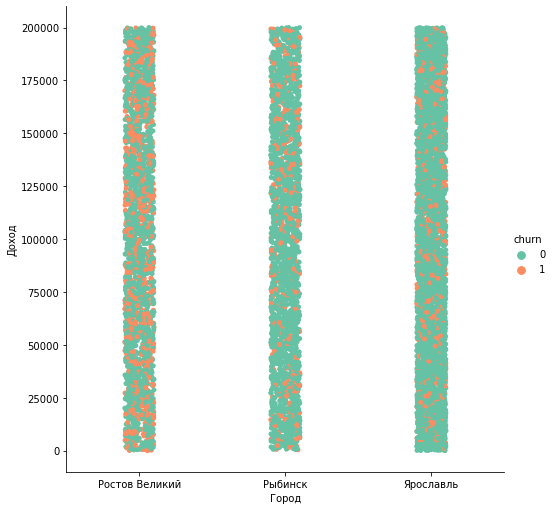

In [17]:
churn_cities = df.pivot_table(index='salary_level', columns = 'city', values = 'churn', aggfunc=['mean','count'])
churn_cities.columns = churn_cities.columns.set_levels(['доля_оттока','количество_в_оттоке'],level=0)

display(churn_cities)

pivot = df.pivot_table(index='salary_level', columns = 'city', values = 'churn', aggfunc='mean', 
                       margins=True, margins_name='Всего')
sns.heatmap(pivot, annot=True, cbar_kws={"orientation": "horizontal"}, cmap='Set2')
plt.title('Доля оттока')
plt.xlabel('Город')
plt.ylabel('Уровень дохода')

df = df.sort_values('city')
sns.catplot(x='city', y='estimated_salary', data=df,
            height=7, hue='churn')
plt.xlabel('Город')
plt.ylabel('Доход')
plt.show()

Отток в Ростове в 2 раза выше, чем в Ярославле и Рыбинске. При этом внутри каждого из этих городов доход ушедших клиентов распределён относительно равномерно.

доля_оттока                                          \
age_level            18-25     25-35     35-45     45-65       65+   
city                                                                 
Ростов Великий    0.156250  0.128726  0.283688  0.652104  0.300000   
Рыбинск           0.088710  0.081365  0.135427  0.387226  0.112676   
Ярославль         0.059072  0.054007  0.144304  0.430245  0.099291   

               количество_в_оттоке                         
age_level                    18-25 25-35 35-45 45-65  65+  
city                                                       
Ростов Великий                  96   738   987   618   70  
Рыбинск                        124   762  1019   501   71  
Ярославль                      237  1722  1975   939  141

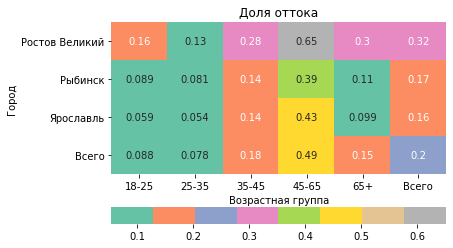

In [18]:
curn_age = df.pivot_table(index='city', columns = 'age_level', values = 'churn', aggfunc=['mean', 'count'])
curn_age.columns = curn_age.columns.set_levels(['доля_оттока','количество_в_оттоке'],level=0)
display(curn_age)

pivot = df.pivot_table(index='city', columns = 'age_level', values = 'churn', aggfunc='mean', 
                       margins=True, margins_name='Всего')

sns.heatmap(pivot, annot=True, cbar_kws={"orientation": "horizontal"}, cmap='Set2')
plt.title('Доля оттока')
plt.xlabel('Возрастная группа')
plt.ylabel('Город')
plt.show()

In [19]:
print('Всего в Ростове в группе 45-65 лет ушло {} клиента, это {:.1%} всего оттока' 
      .format(df.query('city == "Ростов Великий" and churn == 1 and age_level == "45-65"')['userid'].count(),
              df.query('city == "Ростов Великий" and churn == 1 and age_level == "45-65"')['userid'].count() /
              df.query('churn == 1')['userid'].count()))

Всего в Ростове в группе 45-65 лет ушло 403 клиента, это 19.8% всего оттока


доля_оттока                                          \
age_level           18-25     25-35     35-45     45-65       65+   
salary_level                                                        
низкий           0.045455  0.067146  0.188332  0.482283  0.140845   
ниже_среднего    0.087379  0.087131  0.161779  0.460076  0.117647   
выше_среднего    0.099099  0.075995  0.181358  0.473054  0.180556   
высокий          0.112782  0.081181  0.176042  0.529637  0.169014   

              количество_в_оттоке                        
age_level                   18-25 25-35 35-45 45-65 65+  
salary_level                                             
низкий                        110   834   977   508  71  
ниже_среднего                 103   746  1057   526  68  
выше_среднего                 111   829   987   501  72  
высокий                       133   813   960   523  71

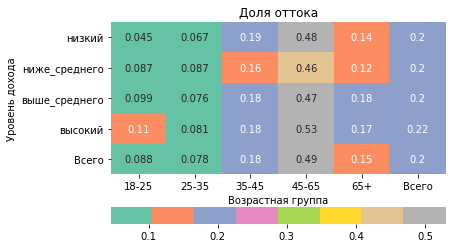

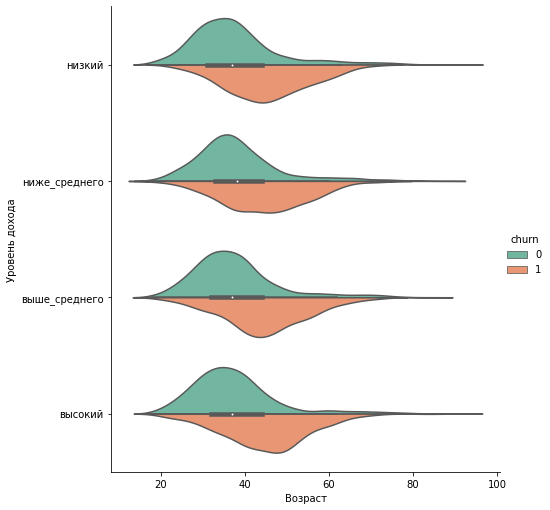

In [20]:
churn_income = df.pivot_table(index='salary_level', columns = 'age_level', values = 'churn', aggfunc=['mean', 'count'])
churn_income.columns = churn_income.columns.set_levels(['доля_оттока','количество_в_оттоке'],level=0)

display(churn_income)

pivot = df.pivot_table(index='salary_level', columns = 'age_level', values = 'churn', aggfunc='mean', 
                       margins=True, margins_name='Всего')
sns.heatmap(pivot, annot=True, cbar_kws={"orientation": "horizontal"}, cmap='Set2')
plt.title('Доля оттока')
plt.xlabel('Возрастная группа')
plt.ylabel('Уровень дохода')

sns.catplot(y='salary_level', x='age', data=df,
            height=7, hue='churn', kind='violin', split=True)
plt.xlabel('Возраст')
plt.ylabel('Уровень дохода');

- В этом срезе мы наблюдаем небольшое увеличение оттока клиентов с более высокими доходами
- Становится еще более очевидным повышенный % оттока клиентов среднего возраста.

### Выводы по склонным к оттоку клиентам:

- В Ростове отток в 2 раза выше, чем в Ярославле и Рыбинске. 
- Самая подверженная уходу возрастная группа 45-65 лет (49% против 7-21% по другим возрастным группам). Проверим эту гипотезу в следующем разделе.
- Всего в Ростове в группе 45-65 лет ушло 403 клиента (19.8% всего оттока, 65% этой группы). Это довольно внушительные цифры, учитывая небольшой объём самой группы = 618 человек.
- Есть незначительное увеличение % оттока в группах с более высоким доходом. Проверим, действительно ли это так в следующем разделе.
- Женщины прекращают обслуживание в банке чеще мужчин.
- Пользователи 3-4 продуктов гораздо чаще уходят, чем остаются (85% в оттоке).

<a id="3"></a>
## Проверка гипотез

### Гипотеза различия дохода между ушедшими и оставшимися клиентами

Для проверки гипотезы выбираем непараметрический тест Уилкоксона-Манна-Уитни, т.к. распределение доходов равномерное, а не нормальное.

- Н0: Распределение доходов ушедших и оставшихся клиентов сопоставимо
- Н1: Распределение доходов ушедших клиентов смещено к верхней границе

Альфа - 0,05

In [21]:
# готовим два датасета для проверки гипотиз
hipo_salary_0 = df.query('churn == 0')['estimated_salary']
hipo_salary_1 = df.query('churn == 1')['estimated_salary'] 

print('p-value {:.3}' .format(st.mannwhitneyu(hipo_salary_1, hipo_salary_0, alternative='greater')[1]))
print('Средний предполагаемый доход активных клиентов: {:.0f}' .format(hipo_salary_0.mean()))
print('Средний предполагаемый доход клиентов в оттоке: {:.0f}' .format(hipo_salary_1.mean()))
print('Доход клиентов в оттоке  выше на {:.1%}' .format(hipo_salary_1.mean() / hipo_salary_0.mean() - 1))

p-value 0.114
Средний предполагаемый доход активных клиентов: 99738
Средний предполагаемый доход клиентов в оттоке: 101466
Доход клиентов в оттоке  выше на 1.7%


- P-value больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что доходы ушедших клиентов выше нельзя.
- Незначительная разница в 1,7% подтверждает сопоставимость доходов. 

### Клиенты 45-65 лет подверженны оттоку в большей степени

Для бинарного распределения (в оттоке/ не в оттоке) так же используем тест Уилкоксона-Манна-Уитни.

- Н0: Отток в возрастных группах одинаков
- Н1: В группе 45-65 лет отток выше

Альфа - 0,05

In [22]:
# готовим два датасета для проверки гипотиз
hipo_45_65 = df.query('age_level == "45-65"')['churn']
hipo_others = df.query('age_level != "45-65"')['churn'] 

print('p-value {:.3}' .format(st.mannwhitneyu(hipo_45_65, hipo_others, alternative='greater')[1]))
print('% оттока в группе 45-65: {:.1%}' .format(hipo_45_65.mean()))
print('% оттока в других возрастных группах: {:.1%}' .format(hipo_others.mean()))

p-value 7.04e-280
% оттока в группе 45-65: 48.6%
% оттока в других возрастных группах: 13.0%


- P-value намного меньше альфа, можем отвергнуть нулевую гипотезу.
- Расчёты так же показывают нам отток группы 45-65 лет более, чем в 3 раза выше.

<a id="4"></a>
## Общие выводы

- В ходе анализа мы не опровергли гипотезу о том, что доходы клиентов в оттоке выше доходов активных клиентов.
- Нам удалось выявить наиболее подверженную оттоку возрастную группу - 45-65 лет. Это тот возраст, когда имеет большое значение возможность накопления, а так же клиентов начинает интересовать пенсионная программа. **Возможно, стоит пересмотреть предлагаемые услуги в этих сферах**.
- В Ростове отток в 2 раза выше, чем в других городах. **Возможно, в Ростове недостаточно отделений/банкоматов банка, либо они неудобны/находятся в неудобных районах**. 
- Самый большой отток в Ростове в группе 45-65 лет ушло 403 клиента (19.8% всего оттока, 65% этой группы). Это довольно внушительные цифры, учитывая небольшой объём самой группы = 618 человек.
- Женщины прекращают обслуживание в банке чеще мужчин.
- Пользователи 3-4 продуктов гораздо чаще уходят, чем остаются. Увеличение недовольства сервисом при более активном пользовании услугами - естественное явление. В этом случае важно проработать "боль" клиента, для того чтобы сделать это во время клиент должен быть замотивирован обратиться в службу поддрержки. **Возможно, служба поддержки банка работает не достаточно профессионально или обращения в нее затруднительны для клиетов.**